In [1]:
# data tools
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pandas as pd
from statistics import mean

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# tf tools
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense)

# problem?
# https://github.com/tensorflow/tensorflow/issues/42175

In [2]:
artists_path = os.path.join("..", "data", "paintings", "training")
artists = os.listdir(artists_path)
artists = artists[0:4] + artists[5:]
artists = sorted(artists)

In [3]:
# Make empty lists, which are to be appended to
train_paintings, train_paintings_artists = [], []
test_paintings, test_paintings_artists = [], []

# For every artist, generate a list of paintings. 
# For every painting in list of paintings. 
# Take the artist name and append it. Take the painting and append it
# //Repeat for test

for artist in artists:
    # Training
    for train_painting in glob.glob(os.path.join("..", "data", "paintings", "training", f"{artist}", "*7.jpg")):
        train_paintings_artists.append(artist)
        train_paintings.append(cv2.imread(train_painting))
    # Testing
    for test_painting in glob.glob(os.path.join("..", "data", "paintings", "validation", f"{artist}", "*7.jpg")):
        test_paintings_artists.append(artist)
        test_paintings.append(cv2.imread(test_painting))

In [4]:
print(len(train_paintings))
print(len(train_paintings_artists))


print(len(test_paintings))
print(len(test_paintings_artists))

389
389
97
97


In [5]:
# Create "resize function"
def resize(paintings, width, height):
    paintings_resized = []
    for painting in paintings:
        # Resize painting
        resized = cv2.resize(painting, (width, height), interpolation = cv2.INTER_AREA)
        # Normalize painting
        resized = resized.astype("float") / 255.
        # Append to list
        paintings_resized.append(resized)
    # Return
    return paintings_resized

# Using the function, to resize all images
train_paintings_resized = resize(train_paintings, 32, 32)
test_paintings_resized = resize(test_paintings, 32, 32)

In [6]:
print(len(train_paintings_resized))
print(len(train_paintings_artists))


print(len(test_paintings_resized))
print(len(test_paintings_artists))

389
389
97
97


In [7]:
# Make ML names for what we have
trainX = train_paintings_resized
trainY = train_paintings_artists

testX = test_paintings_resized
testY = test_paintings_artists

In [8]:
# Binarize labels
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

# Initialize label names for CIFAR-10 dataset
labelNames = artists

# Here we know that the order is the same in "artists", so we know how to map the binarized labels onto the string names

In [9]:
print(trainX[0].shape)
print(trainY[:5])
print(trainY.shape)
print(testX[0].shape)
print(testY[:5])
print(testY.shape)

(32, 32, 3)
[[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
(389, 10)
(32, 32, 3)
[[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
(97, 10)


In [10]:
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testX))
print(trainX[0].shape)
print(testX[0].shape)

389
389
97
97
(32, 32, 3)
(32, 32, 3)


# Now for the modeling and prediction

In [11]:
# initialise model
model = Sequential()

# define CONV => RELU layer
model.add(Conv2D(32, (3, 3),
                 padding="same", 
                 input_shape=(32, 32, 3)))
model.add(Activation("relu"))

# softmax classifier
model.add(Flatten())
model.add(Dense(10))
model.add(Activation("softmax"))

In [12]:
opt = SGD(lr =.01)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                327690    
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 328,586
Trainable params: 328,586
Non-trainable params: 0
_________________________________________________________________


In [14]:
def plot_history(H, epochs):
    # visualize performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

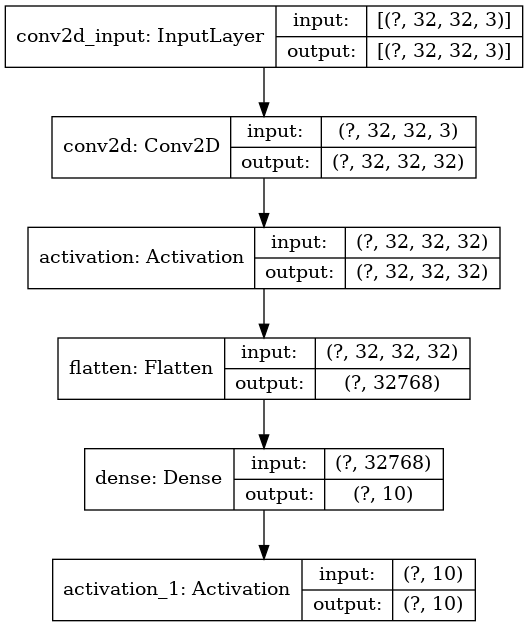

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [16]:
H = model.fit(trainX, trainY, 
              validation_data=(testX, testY), 
              batch_size=32,
              epochs=10,
              verbose=1)

ValueError: Error when checking input: expected conv2d_input to have 4 dimensions, but got array with shape (32, 32, 3)

In [ ]:
predictions = model.predict(testX, batch_size=32)

In [ ]:
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

In [307]:
plot_history(H, 10)

NameError: name 'H' is not defined

In [ ]:
# Extract a list of heights and widths of all train images
widths = []
heights = []

# For each painting in train_paintings - extract painting width and height, and append to list
for painting in train_paintings:
    width = painting.shape[1]
    widths.append(width)
    
    height = painting.shape[0]
    heights.append(height)
    
mean_width = int(mean(widths))
mean_height = int(mean(heights))